In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras



# LOAD DATA

In [2]:
df = pd.read_csv('datasetiot.csv')
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
#set category types
df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)
df.head()
# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'FTP'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'SSH'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:26429, 'label'] = 'FTP + SSH'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'FTP + SSH'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'FTP + SSH'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'




C:\Users\enzoh\AppData\Local\Temp\ipykernel_44148\2390272622.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


# Visulation of the data

In [3]:
# print column names
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


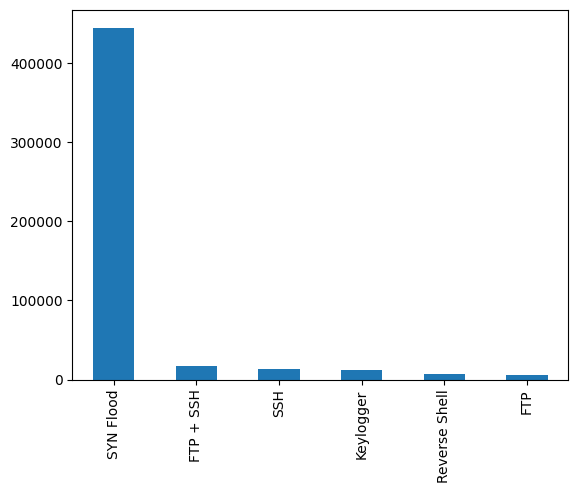

In [4]:
# show and plot  the number of samples for each label
df['label'].value_counts().plot(kind='bar')
plt.show()
# show the number of samples for each label
df['label'].value_counts()
# labels is all the labels
labels = df['label'].values


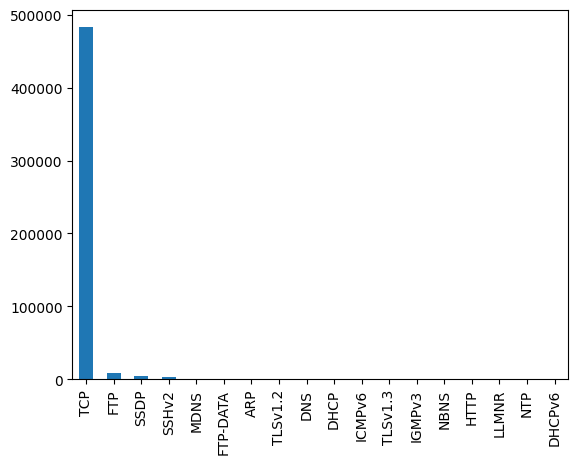

TCP         482847
FTP           8029
SSDP          4668
SSHv2         3806
MDNS           543
FTP-DATA       511
ARP            401
TLSv1.2        354
DNS            352
DHCP           136
ICMPv6         123
TLSv1.3        120
IGMPv3         112
NBNS            72
HTTP            49
LLMNR           48
NTP             24
DHCPv6           6
Name: Protocol, dtype: int64

In [5]:
# show count for each protocol
df['Protocol'].value_counts().plot(kind='bar')
plt.show()
# show count for each protocol
df['Protocol'].value_counts()


# LSTM model

In [6]:
from sklearn.preprocessing import LabelEncoder

import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_data(df, window_size=128):
    """Prepare the data for the LSTM model. Normalize the data, and transform objects to numerical values.

    Args:
        df: pandas dataframe
        window_size: the number of samples to put in a sequence

    Returns:
        Tuple: X, y
            - X (np.array): Features.
            - y (np.array): Labels.
    """

    # Extract relevant features
    X = df.drop('label', axis=1)  # Drop the label column
    y = df['label']

    # Label encoding for categorical columns
    label_encoder = LabelEncoder()
    X_encoded = X.apply(label_encoder.fit_transform)  # Apply label encoding to all columns

    # encode the labels
    y_encoded = label_encoder.fit_transform(y)


    # Create sliding window sequences of data
    num_samples = len(X_encoded)
    num_features = X_encoded.shape[1]
    X_sequences = np.zeros((num_samples - window_size + 1, window_size, num_features))
    y_labels = np.zeros((num_samples - window_size + 1,), dtype=int)
    for i in range(num_samples - window_size + 1):
        X_sequences[i] = X_encoded[i:i + window_size]
        y_labels[i] = y_encoded[i + window_size - 1]
    return X_sequences, y_labels, label_encoder

    





In [7]:
# Define the indices for training, validation, and test sets
train_indices = [(0, 3500), (5150, 13000), (18600, 24500), (28000, 35000), (40100, 44500), (46500, 51500), (int(54101), int((len(df)-54101)*0.8))]
val_indices = [(3501, 4300), (13001, 15500), (24501, 26500), (35001, 37500), (44501, 45000), (51501, 52000), (int((len(df)-54101)*0.8), int((len(df)-54101)*0.9))]
test_indices = [(4301, 5150), (15501, 18600), (26501, 28000), (37501, 40100), (45001, 46500), (52001, 54100), (int((len(df)-54101)*0.9), int(len(df)-54101))]

# create the training, validation, and test dataframes, including the parts inside each tuple
train_df = pd.concat([df.iloc[start:end] for start, end in train_indices])
val_df = pd.concat([df.iloc[start:end] for start, end in val_indices])
test_df = pd.concat([df.iloc[start:end] for start, end in test_indices])

# print shapes
print(train_df.shape, val_df.shape, test_df.shape)

# reset the indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


#print all dtypes
print(train_df.dtypes)
print(val_df.dtypes)
print(test_df.dtypes)
window_size = 128
train_df_data, train_target,label_encoder_train = prepare_data(train_df, window_size)
val_df_data, val_target,label_encoder_val = prepare_data(val_df, window_size)
test_df_data, test_target, label_encoder_test= prepare_data(test_df, window_size)
# print("aaaaaaaaaaaaa",train_df_data.shape, train_target.shape)
# val_df_data, val_target = prepare_data(val_df)
# test_df_data, test_target = prepare_data(test_df)
# num_features = train_df_data.shape[2]




(338029, 8) (53604, 8) (56454, 8)
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object


In [17]:
# train lstm smodel_stacked_LSTM
num_features = train_df_data.shape[2]
input_shape = (window_size, num_features)

smodel_stacked_LSTM = keras.Sequential()
smodel_stacked_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(64, return_sequences=True))
smodel_stacked_LSTM.add(keras.layers.LSTM(64))
smodel_stacked_LSTM.add(keras.layers.Dense(32, activation='relu'))
smodel_stacked_LSTM.add(keras.layers.Dense(7, activation='softmax'))
smodel_stacked_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
smodel_stacked_LSTM.summary()

model_single_LSTM = keras.Sequential()
model_single_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
model_single_LSTM.add(keras.layers.LSTM(64))
model_single_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_single_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_single_LSTM.summary()

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN.add(keras.layers.Flatten())
model_CNN.add(keras.layers.Dense(50, activation='relu'))
model_CNN.add(keras.layers.Dense(7, activation='softmax'))
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN.summary()

model_CNN_LSTM = keras.Sequential()
model_CNN_LSTM.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
model_CNN_LSTM.add(keras.layers.MaxPooling1D(pool_size=2))
model_CNN_LSTM.add(keras.layers.LSTM(128, return_sequences=True))
model_CNN_LSTM.add(keras.layers.LSTM(64))
model_CNN_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_CNN_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_CNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_CNN_LSTM.summary()

model_bidirectional_LSTM = keras.Sequential()
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True), input_shape=input_shape))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)))
model_bidirectional_LSTM.add(keras.layers.Bidirectional(keras.layers.LSTM(64)))
model_bidirectional_LSTM.add(keras.layers.Dense(32, activation='relu'))
model_bidirectional_LSTM.add(keras.layers.Dense(7, activation='softmax'))
model_bidirectional_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bidirectional_LSTM.summary()

model_RNN = keras.Sequential()
model_RNN.add(keras.layers.SimpleRNN(128, input_shape=input_shape, return_sequences=True))
model_RNN.add(keras.layers.SimpleRNN(128, return_sequences=True))
model_RNN.add(keras.layers.SimpleRNN(64))
model_RNN.add(keras.layers.Dense(32, activation='relu'))
model_RNN.add(keras.layers.Dense(7, activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_RNN.summary()


model_list = [smodel_stacked_LSTM, model_single_LSTM, model_CNN, model_CNN_LSTM, model_bidirectional_LSTM, model_RNN]




Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128, 128)          69632     
                                                                 
 lstm_11 (LSTM)              (None, 128, 128)          131584    
                                                                 
 lstm_12 (LSTM)              (None, 128, 64)           49408     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 7)                 231       
                                                                 
Total params: 285,959
Trainable params: 285,959
Non-tr

In [9]:
# show how len many unique labels there are
print(len(np.unique(train_target)))

6


In [10]:
smodel_stacked_LSTM.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 128)          69632     
                                                                 
 lstm_1 (LSTM)               (None, 128, 128)          131584    
                                                                 
 lstm_2 (LSTM)               (None, 128, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 285,959
Trainable params: 285,959
Non-trai

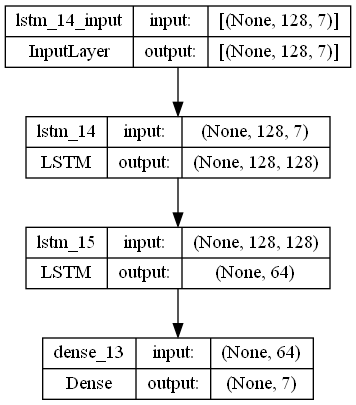

In [18]:
#draw model
from keras.utils.vis_utils import plot_model
plot_model(smodel_stacked_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# plot single model
plot_model(model_single_LSTM, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



In [12]:
#show GPU info
!nvidia-smi


Wed Apr  5 02:21:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.02       Driver Version: 528.02       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0    29W / 141W |   6055MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:

history_single_LSTM = model_single_LSTM.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
history_CNN = model_CNN.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
history_CNN_LSTM = model_CNN_LSTM.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
history_bidirectional_LSTM = model_bidirectional_LSTM.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
history_RNN = model_RNN.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))
history_stacked_LSTM = smodel_stacked_LSTM.fit(train_df_data, train_target, epochs=5, batch_size=128, validation_data=(val_df_data, val_target))

Epoch 1/5
 820/2640 [========>.....................] - ETA: 44s - loss: 0.0593 - accuracy: 0.9829

In [14]:
# show confusion matrix with original labels
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = smodel_stacked_LSTM.predict(test_df_data)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_target, y_pred)
# confusion report
print(classification_report(test_target, y_pred, target_names=labels))

NameError: name 'smodel_stacked_LSTM' is not defined